# BT4012 Group 26 Final Project

## Imported packages

In [2]:
# Data Pre-Processing
# from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Models 
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE 
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.pipeline import Pipeline
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from hpsklearn import HyperoptEstimator
from hpsklearn import any_regressor

# Model Evaluation
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.metrics import plot_roc_curve, roc_curve
# Ignore warnings
import warnings
warnings.filterwarnings('ignore') 

## Load dataset 

In [4]:
#Upload fraud_oracle.csv into your Google Drive
fraud_df = pd.read_csv('/Users/remuslum/Downloads/fraud_oracle.csv')
fraud_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15420 entries, 0 to 15419
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Month                 15420 non-null  object
 1   WeekOfMonth           15420 non-null  int64 
 2   DayOfWeek             15420 non-null  object
 3   Make                  15420 non-null  object
 4   AccidentArea          15420 non-null  object
 5   DayOfWeekClaimed      15420 non-null  object
 6   MonthClaimed          15420 non-null  object
 7   WeekOfMonthClaimed    15420 non-null  int64 
 8   Sex                   15420 non-null  object
 9   MaritalStatus         15420 non-null  object
 10  Age                   15420 non-null  int64 
 11  Fault                 15420 non-null  object
 12  PolicyType            15420 non-null  object
 13  VehicleCategory       15420 non-null  object
 14  VehiclePrice          15420 non-null  object
 15  FraudFound_P          15420 non-null

Our **target variable** is FraudFound_P, which indicates whether a case was fradulent or not. 

There are a total of **8 numerical variables** (WeekOfMonth, WeekOfMonthClaimed, Age, PolicyNumber, RepNumber, Deductible, DriverRating, Year).

There are a total of **24 categorical variables** (Month, DayOfWeek, Make, AccidentArea, DayOfWeekClaimed, MonthClaimed, Sex, MaritalStatus, Fault, PolicyType, VehicleCategory, VehiclePrice, Days_Policy_Accident, Days_Policy_Claim, PastNumberOfClaims, AgeOfVehicle, AgeOfPolicyHolder, PoliceReportFiled,
WitnessPresent, AgentType, NumberOfSuppliments, AddressChange_Claim, NumberOfCars, BasePolicy). 

In [81]:
fraud_df.isna().sum()

Month                   0
WeekOfMonth             0
DayOfWeek               0
Make                    0
AccidentArea            0
DayOfWeekClaimed        0
MonthClaimed            0
WeekOfMonthClaimed      0
Sex                     0
MaritalStatus           0
Age                     0
Fault                   0
PolicyType              0
VehicleCategory         0
VehiclePrice            0
FraudFound_P            0
PolicyNumber            0
RepNumber               0
Deductible              0
DriverRating            0
Days_Policy_Accident    0
Days_Policy_Claim       0
PastNumberOfClaims      0
AgeOfVehicle            0
AgeOfPolicyHolder       0
PoliceReportFiled       0
WitnessPresent          0
AgentType               0
NumberOfSuppliments     0
AddressChange_Claim     0
NumberOfCars            0
Year                    0
BasePolicy              0
dtype: int64

There seems to be no missing values in the dataset.

## Data Exploration

### Numerical Variables
We will first investigate the descriptive statistics of the numerical variables, distribution of the values and the density estimate plot.

In [80]:
target_variable = ["FraudFound_P"]
numerical_variables = ["WeekOfMonth", "WeekOfMonthClaimed", "Age", "PolicyNumber", "RepNumber", 
                       "Deductible", "DriverRating", "Year"]
categorical_variables = ["Month", "DayOfWeek", "Make", "AccidentArea", "DayOfWeekClaimed", "MonthClaimed", "Sex", 
                         "MaritalStatus", "Fault", "PolicyType", "VehicleCategory", "VehiclePrice", 
                         "Days_Policy_Accident", "Days_Policy_Claim", "PastNumberOfClaims", 
                         "AgeOfVehicle", "AgeOfPolicyHolder", "PoliceReportFiled",
                        "WitnessPresent", "AgentType", "NumberOfSuppliments", 
                         "AddressChange_Claim", "NumberOfCars", "BasePolicy"]

In [12]:
quantile = fraud_df[numerical_variables].describe().loc[['min', '25%', '50%', '75%', 'max']].transpose()
quantile.columns = ['min', 'Q1', 'Q2', 'Q3', 'max']
quantile['range'] = quantile['max'] - quantile['min']
quantile['IQR'] = quantile['Q3'] - quantile['Q1']
quantile

,min,Q1,Q2,Q3,max,range,IQR
WeekOfMonth,1.0,2.00,3.0,4.00,5.0,4.0,2.0
WeekOfMonthClaimed,1.0,2.00,3.0,4.00,5.0,4.0,2.0
Age,0.0,31.00,38.0,48.00,80.0,80.0,17.0
PolicyNumber,1.0,3855.75,7710.5,11565.25,15420.0,15419.0,7709.5
RepNumber,1.0,5.00,8.0,12.00,16.0,15.0,7.0
Deductible,300.0,400.00,400.0,400.00,700.0,400.0,0.0
DriverRating,1.0,1.00,2.0,3.00,4.0,3.0,2.0
Year,1994.0,1994.00,1995.0,1996.00,1996.0,2.0,2.0


In [13]:
descriptive_stats = fraud_df[numerical_variables].describe().loc[['mean', 'std', '50%']].transpose()
descriptive_stats.columns = ['mean', 'std', 'median']
descriptive_stats['mode'] = fraud_df[numerical_variables].mode().transpose()[0]
# Function for median_abs_deviation calculation
descriptive_stats['MAD'] = [stats.median_abs_deviation(fraud_df[x]) for x in numerical_variables]
descriptive_stats['kurtosis'] = [stats.kurtosis(fraud_df[x], fisher=False) for x in numerical_variables]
descriptive_stats['excess kurtosis'] = [stats.kurtosis(fraud_df[x], fisher=True) for x in numerical_variables]
# Fisher is the variable that determines whether kurtosis or excess kurtosis is calculated
descriptive_stats['skewness'] = [stats.skew(fraud_df[x]) for x in numerical_variables]
descriptive_stats

,mean,std,median,mode,MAD,kurtosis,excess kurtosis,skewness
WeekOfMonth,2.788586,1.287585,3.0,3.0,1.0,1.898811,-1.101189,0.115415
WeekOfMonthClaimed,2.693969,1.259115,3.0,2.0,1.0,1.914408,-1.085592,0.158218
Age,39.855707,13.492377,38.0,30.0,8.0,3.798018,0.798018,0.152299
PolicyNumber,7710.500000,4451.514911,7710.5,1.0,3855.0,1.800000,-1.200000,0.000000
RepNumber,8.483268,4.599948,8.0,7.0,4.0,1.808121,-1.191879,0.006627
Deductible,407.704280,43.950998,400.0,400.0,0.0,39.810449,36.810449,6.078212
DriverRating,2.487808,1.119453,2.0,1.0,1.0,1.636767,-1.363233,0.009282
Year,1994.866472,0.803313,1995.0,1994.0,1.0,1.589353,-1.410647,0.245665


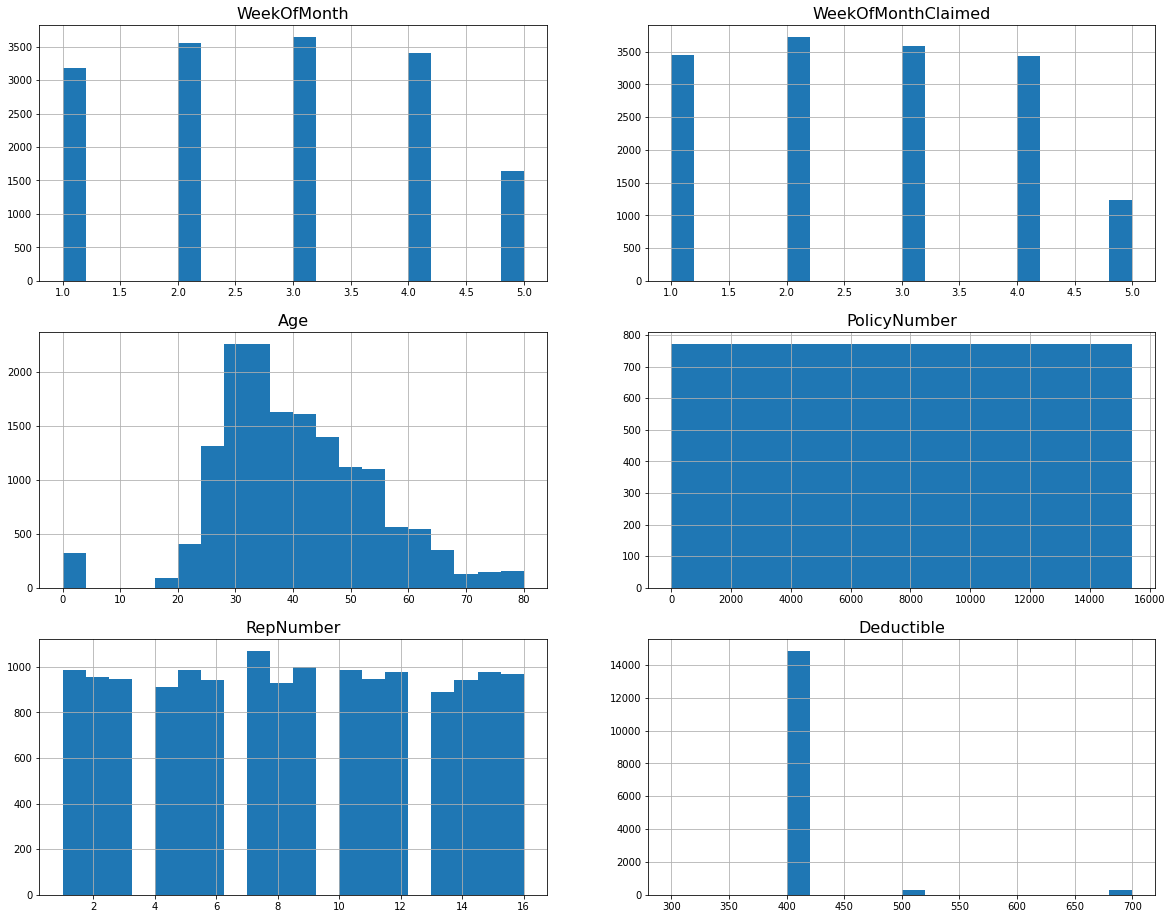

In [14]:
plt.figure(figsize=(20,16))
plt.subplot(321)
axes = [None] * len(numerical_variables)
for index, name in enumerate(fraud_df[numerical_variables].columns):
    if index == 6:
        break
    else :
        axes[index] = plt.subplot(3, 2, index+1, label=str(index))
        fraud_df[name].hist(ax=axes[index], bins=20)
        axes[index].set_title(name, fontsize=16)

mean               2.788586
std                1.287585
median             3.000000
mode               3.000000
MAD                1.000000
kurtosis           1.898811
excess kurtosis   -1.101189
skewness           0.115415
Name: WeekOfMonth, dtype: float64


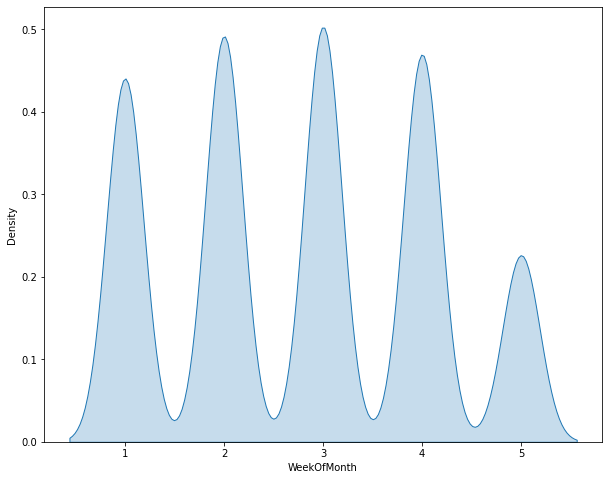

mean               2.693969
std                1.259115
median             3.000000
mode               2.000000
MAD                1.000000
kurtosis           1.914408
excess kurtosis   -1.085592
skewness           0.158218
Name: WeekOfMonthClaimed, dtype: float64


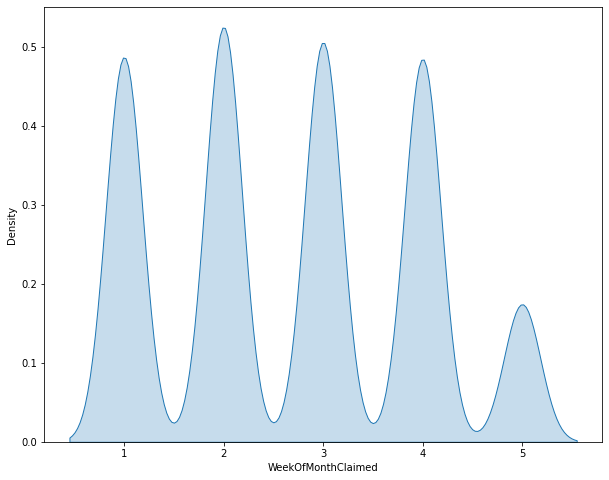

mean               39.855707
std                13.492377
median             38.000000
mode               30.000000
MAD                 8.000000
kurtosis            3.798018
excess kurtosis     0.798018
skewness            0.152299
Name: Age, dtype: float64


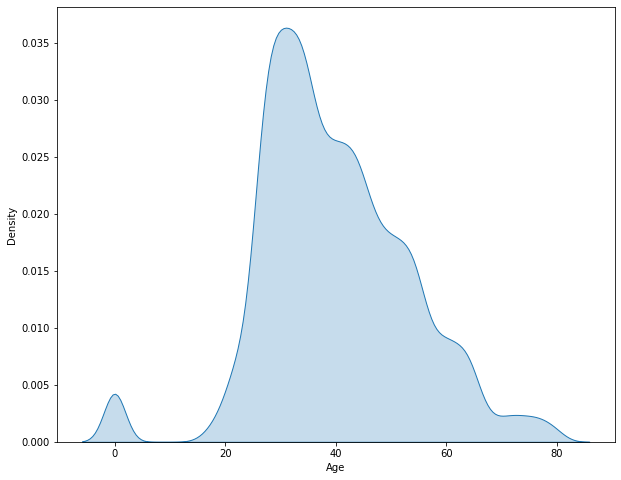

mean               7710.500000
std                4451.514911
median             7710.500000
mode                  1.000000
MAD                3855.000000
kurtosis              1.800000
excess kurtosis      -1.200000
skewness              0.000000
Name: PolicyNumber, dtype: float64


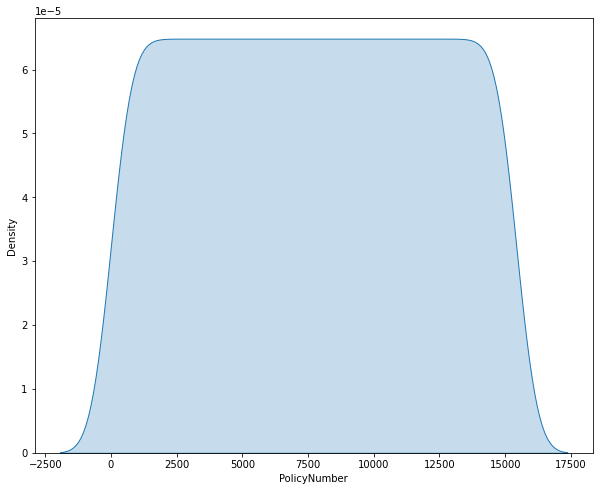

mean               8.483268
std                4.599948
median             8.000000
mode               7.000000
MAD                4.000000
kurtosis           1.808121
excess kurtosis   -1.191879
skewness           0.006627
Name: RepNumber, dtype: float64


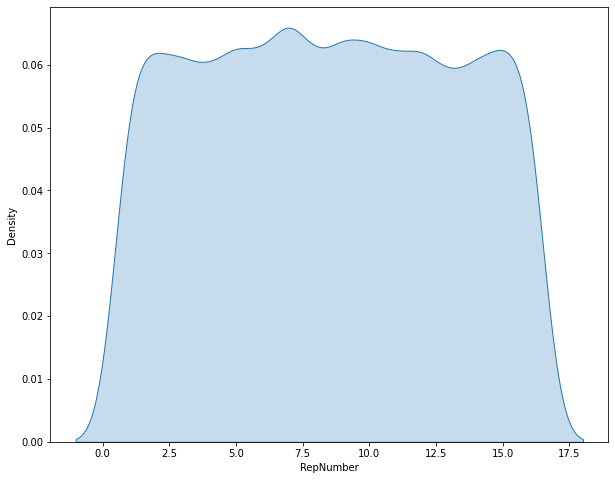

mean               407.704280
std                 43.950998
median             400.000000
mode               400.000000
MAD                  0.000000
kurtosis            39.810449
excess kurtosis     36.810449
skewness             6.078212
Name: Deductible, dtype: float64


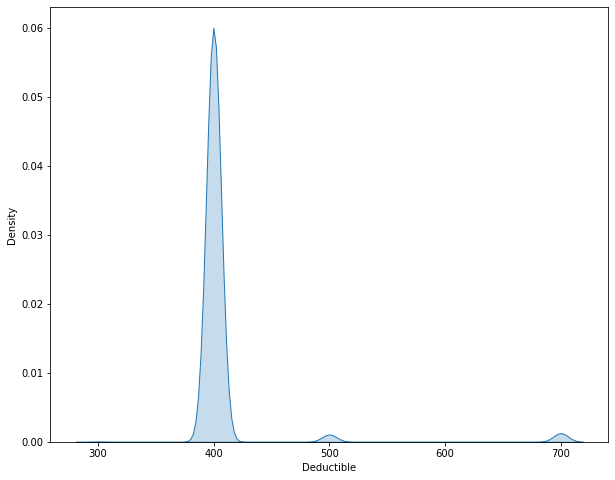

mean               2.487808
std                1.119453
median             2.000000
mode               1.000000
MAD                1.000000
kurtosis           1.636767
excess kurtosis   -1.363233
skewness           0.009282
Name: DriverRating, dtype: float64


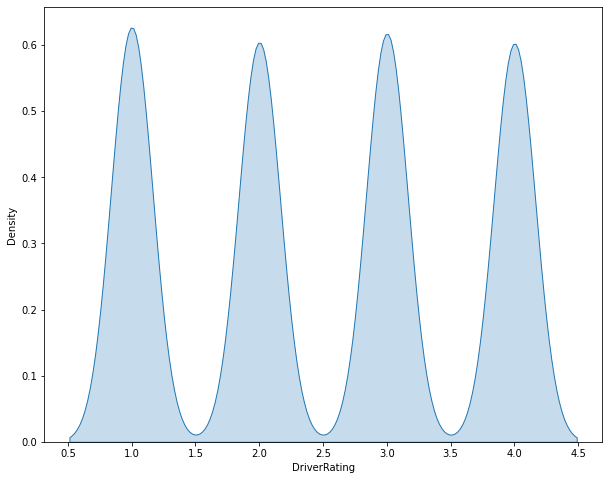

mean               1994.866472
std                   0.803313
median             1995.000000
mode               1994.000000
MAD                   1.000000
kurtosis              1.589353
excess kurtosis      -1.410647
skewness              0.245665
Name: Year, dtype: float64


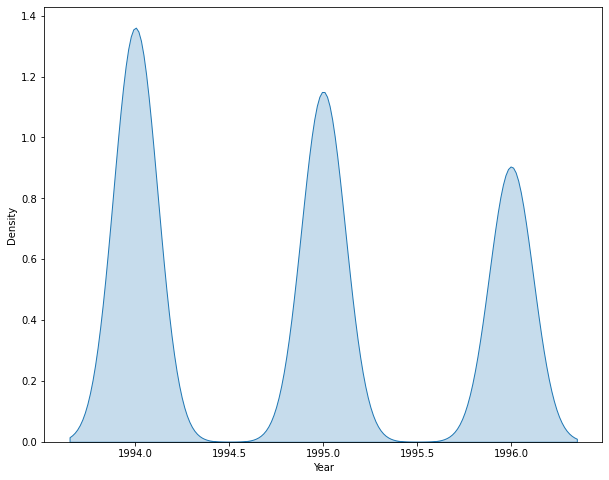

In [15]:
for var in numerical_variables:
  fig = plt.figure(figsize = (10, 8))
  print (descriptive_stats.loc[var])
  sns.kdeplot(fraud_df[var], fill=True)
  plt.show()

Our data seems to be randomly distributed throughout the dataset. 

However, there seems to be 2 things that stand out: 
1. Majority of the values of deductibles seem to centered around 400
2. In our "Age" variable, there is a significant amount of points with the value "0". 

The deductibles are not much of a concern as most insurance policies have a standard deductible amount that can be used so perhaps the policies during that time had a standard deductible amount of 400 that everyone was eligible for. However, having "Age" = 0 is of concern as there cannot be someone who does not have an age. This could be due to underage driving in the U.S. and the claimee did not reveal their age due to fear of getting caught or illegal immigrants who do not want to be discovered. 

### Variable Exploration - Age

We first extract the rows with "Age" = 0 and investigate the statistics of the numerical and categorical variables and investigate the possible effects of removing these rows from our dataset. 

In [6]:
zero_age_rows = fraud_df[fraud_df["Age"]==0]
zero_age_rows.head()

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,...,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy
7,Nov,1,Friday,Honda,Urban,Tuesday,Mar,4,Male,Single,...,new,16 to 17,No,No,External,none,no change,1 vehicle,1994,Collision
13,Jan,5,Friday,Honda,Rural,Wednesday,Feb,1,Male,Single,...,new,16 to 17,No,No,External,none,no change,1 vehicle,1994,Collision
28,Jul,1,Saturday,Honda,Urban,Tuesday,Sep,4,Male,Single,...,new,16 to 17,No,No,External,none,no change,1 vehicle,1994,All Perils
31,Mar,1,Sunday,Honda,Urban,Tuesday,Mar,2,Male,Single,...,new,16 to 17,No,No,External,none,no change,1 vehicle,1994,Collision
58,May,1,Monday,Honda,Rural,Wednesday,May,4,Male,Single,...,new,16 to 17,No,No,External,none,no change,1 vehicle,1994,Liability


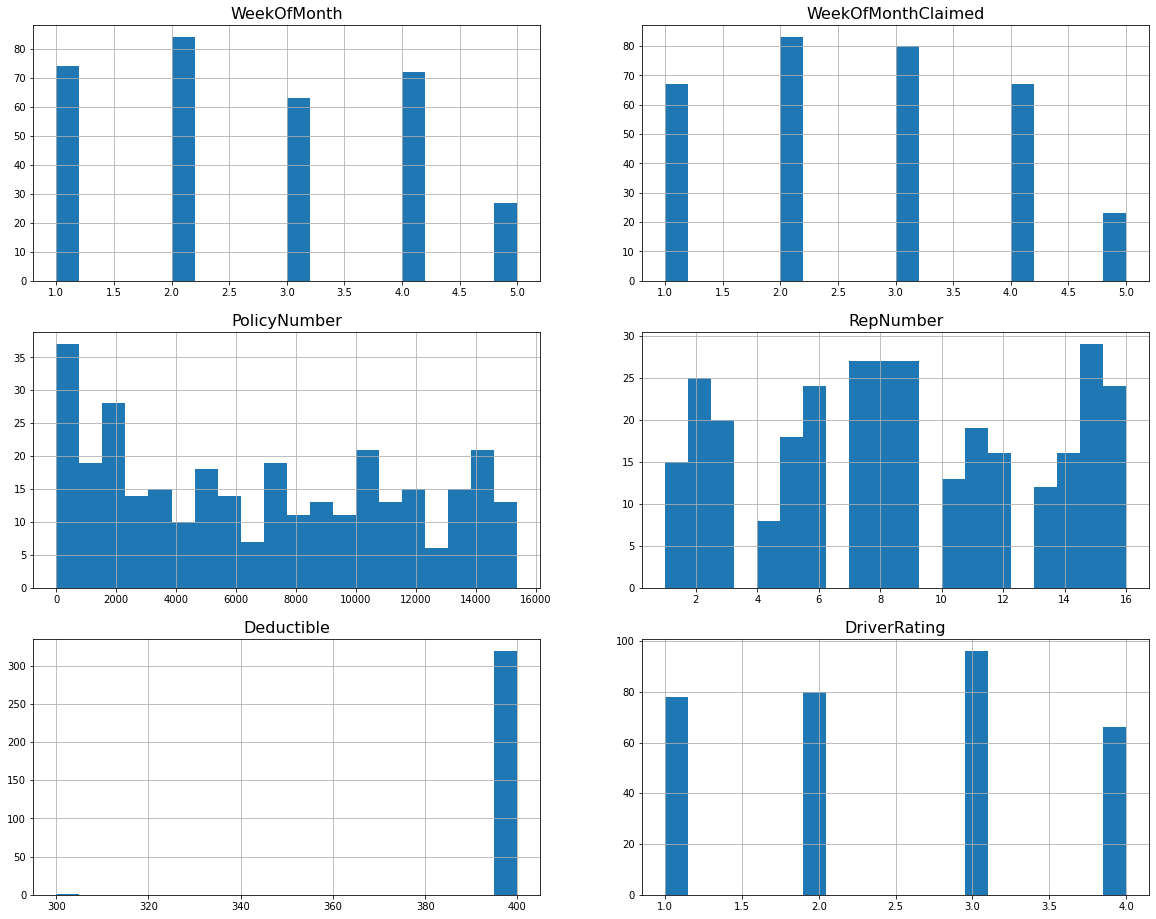

In [84]:
# Removal of age in numerical variables
age_numerical_variables = ["WeekOfMonth", "WeekOfMonthClaimed", "PolicyNumber", "RepNumber", 
                       "Deductible", "DriverRating", "Year"]
plt.figure(figsize=(20,16))
plt.subplot(321)
axes = [None] * len(age_numerical_variables)
for index, name in enumerate(zero_age_rows[age_numerical_variables].columns):
    if index == 6:
        break
    else :
        axes[index] = plt.subplot(3, 2, index+1, label=str(index))
        zero_age_rows[name].hist(ax=axes[index], bins=20)
        axes[index].set_title(name, fontsize=16)

All rows have a "Deductible" value of 400 while the rest of the variables have values that are evenly spreaded out. 

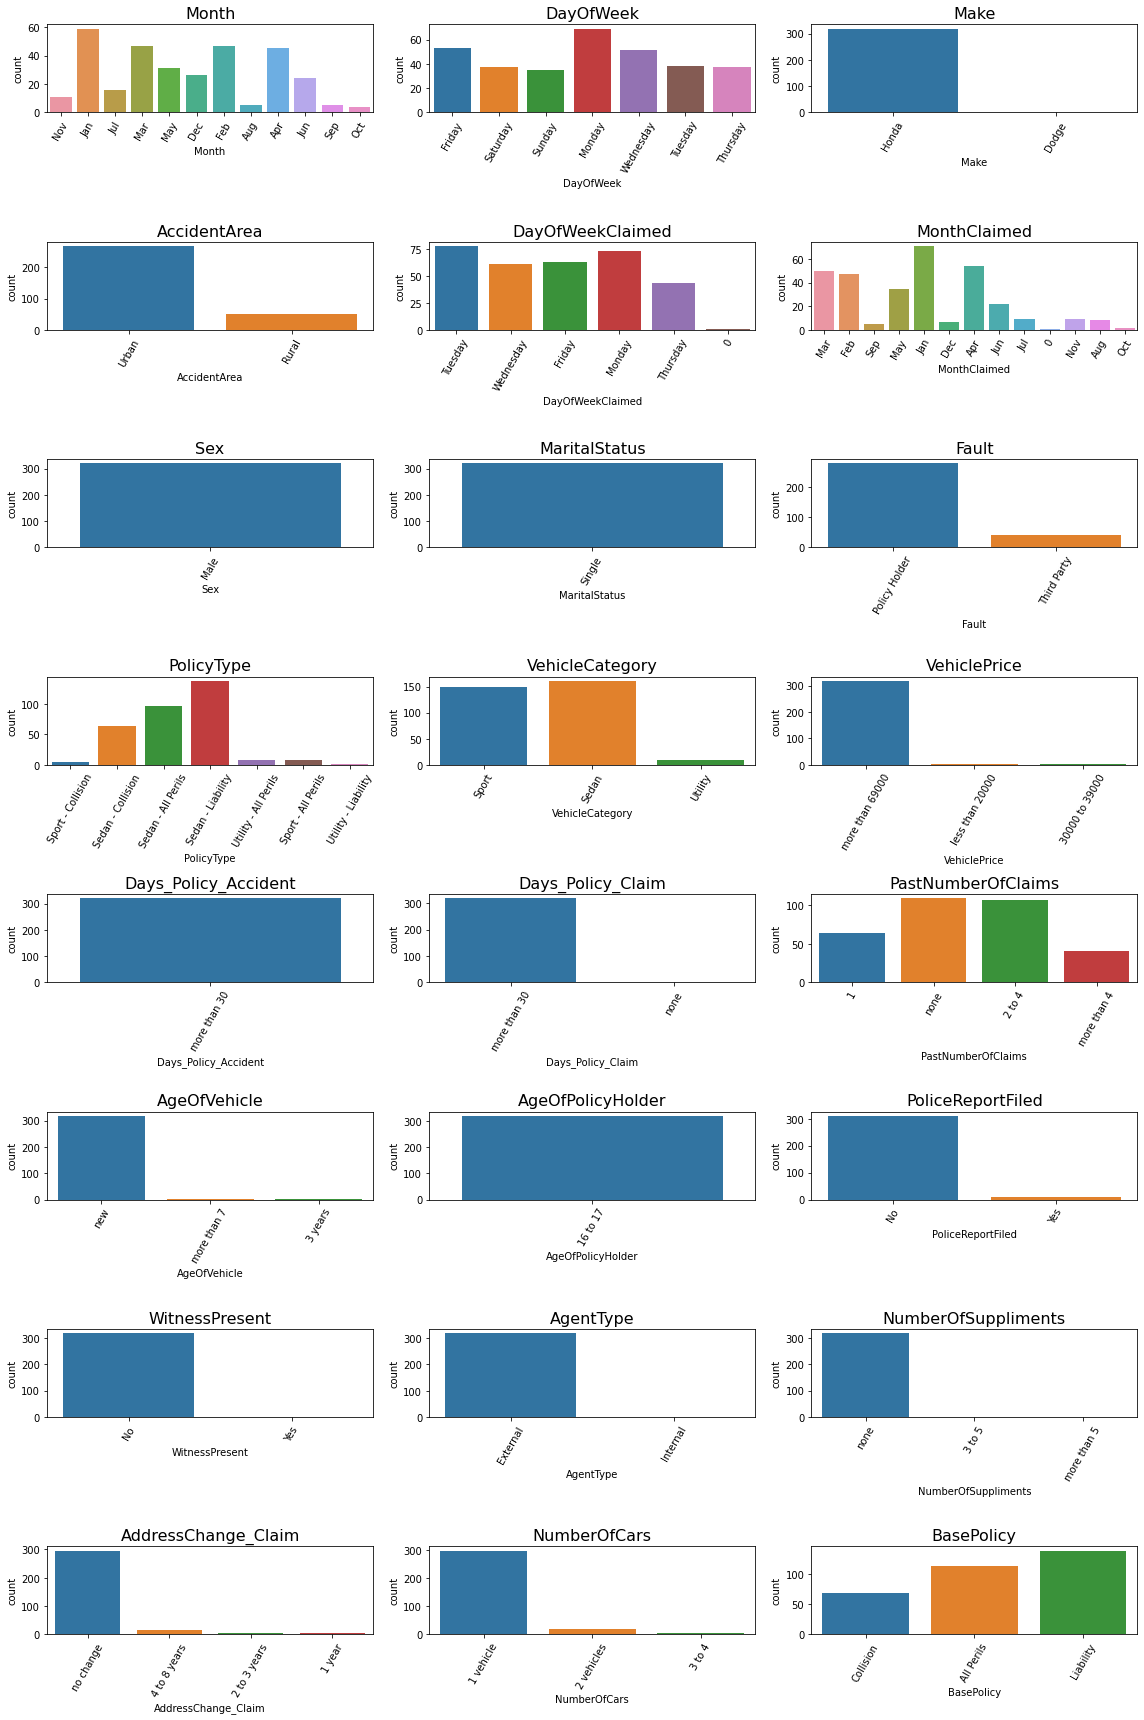

In [85]:
f, axes = plt.subplots(8, 3, figsize=(16, 24), sharex=False)
for index, name in enumerate(categorical_variables):
    sns.countplot(x=name, data=zero_age_rows, ax=axes[index//3,index%3])
    axes[index//3,index%3].set_title(name, fontsize=16)
    axes[index//3,index%3].set_xticklabels(axes[index//3,index%3].get_xticklabels(), rotation=60)
    
plt.tight_layout()

All rows have the same value for the following variables:
1. Make = "Honda"
2. Sex = "Male"
3. MaritalStatus = "Single"
4. Days_Policy_Accident = "More than 30"
5. AgeOfPolicyHolder = "16 to 17"
6. NumberOfSuppliments = "none" 

Hence, we conclude that this is a case of missing value at random and eliminating these rows will skew our data and is not an appropriate approach. Therefore, we will instead replace the value with the **median value of "Age"** to retain the information provided. 

### Categorical Variables

We now explore the categorical variables of the dataset and see the number of categories in each variables and the number of observations per category.

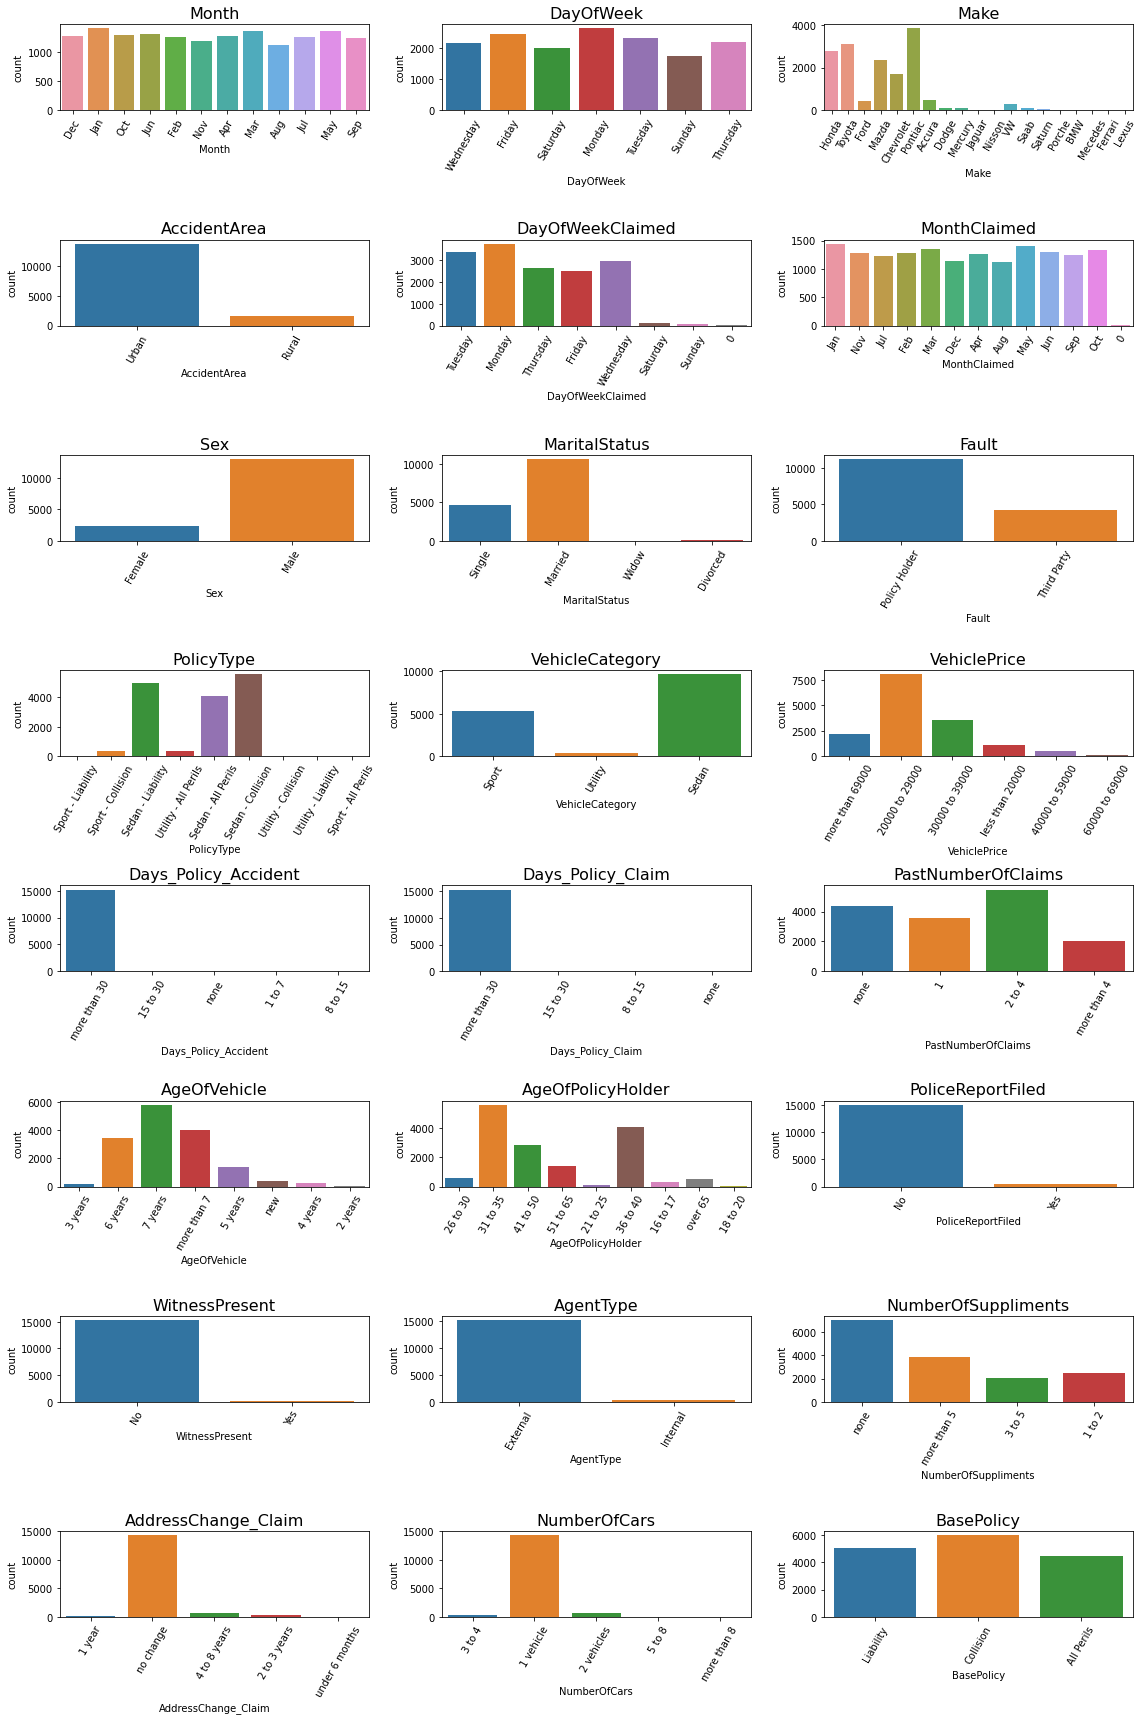

In [16]:
f, axes = plt.subplots(8, 3, figsize=(16, 24), sharex=False)
for index, name in enumerate(categorical_variables):
    sns.countplot(x=name, data=fraud_df, ax=axes[index//3,index%3])
    axes[index//3,index%3].set_title(name, fontsize=16)
    axes[index//3,index%3].set_xticklabels(axes[index//3,index%3].get_xticklabels(), rotation=60)
    
plt.tight_layout()

## Feature Selection

We now conduct feature selection and identify the variables that will help us in predicting a fradulent insurance claim. To do this, we plot a correlation heatmap and identify the variables that are correlated with one another and minimise the total number of features used in our models. 

Our threshold is set at 0.8 and any 2 variables with a correlation coefficient are taken as correlated variables while those below are not correlated. 

### Numerical Variables

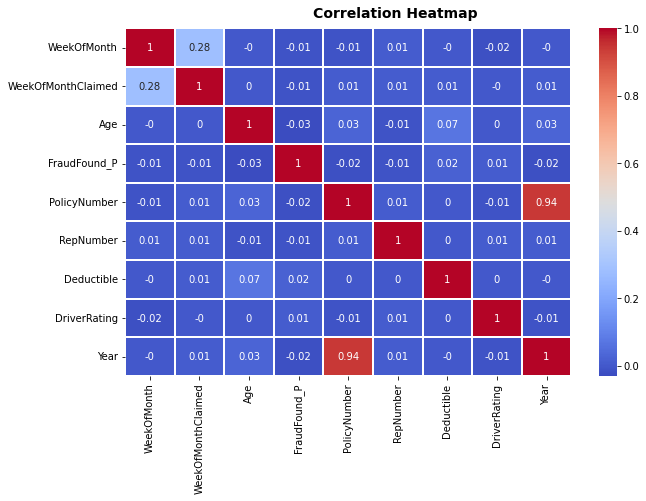

In [86]:
fig, ax = plt.subplots(1,1, figsize=(10,6))

hm = sns.heatmap(round(fraud_df.corr(),2), 
                 ax=ax,           # Axes in which to draw the plot, otherwise use the currently-active Axes.
                 cmap="coolwarm", # Color Map.
                 #square=True,    # If True, set the Axes aspect to “equal” so each cell will be square-shaped.
                 annot=True, 
                 #annot_kws={"size": 14},
                 linewidths=.05)

fig.subplots_adjust(top=0.93)

t = fig.suptitle('Correlation Heatmap', fontsize=14, fontweight='bold')

The variables PolicyNumber and Year are **correlated** with a correlation coefficient on 0.94. Hence, we will remove the variable Year from our features.

In [22]:
p_values = []
chai_stats = []
for cat1 in categorical_variables:
    for cat2 in categorical_variables:
            crosstab = pd.crosstab(fraud_df[cat1], fraud_df[cat2])
            chai2, p_val, _, _ = stats.chi2_contingency(crosstab)
            p_values.append((cat1, cat2, p_val))
            chai_stats.append((cat1, cat2, chai2))
     

chisquare = pd.DataFrame(p_values, columns=['cat1', 'cat2', 'p-value'])
chisquare.pivot_table(index='cat1', columns='cat2', values='p-value')

cat2,AccidentArea,AddressChange_Claim,AgeOfPolicyHolder,AgeOfVehicle,AgentType,BasePolicy,DayOfWeek,DayOfWeekClaimed,Days_Policy_Accident,Days_Policy_Claim,...,MonthClaimed,NumberOfCars,NumberOfSuppliments,PastNumberOfClaims,PoliceReportFiled,PolicyType,Sex,VehicleCategory,VehiclePrice,WitnessPresent
cat1,,,,,,,,,,,,,,,,,,,,,
AccidentArea,0.000000e+00,7.808236e-03,8.412421e-02,1.102298e-01,5.906945e-01,1.314621e-11,2.069020e-02,1.594323e-02,4.307512e-01,2.479742e-02,...,1.615733e-02,3.325791e-01,9.689020e-02,3.787779e-13,8.907027e-01,9.784281e-14,3.162758e-05,7.128107e-15,6.538201e-02,8.210657e-04
AddressChange_Claim,7.808236e-03,0.000000e+00,6.607127e-01,8.883278e-02,2.415473e-02,3.820731e-01,7.666320e-01,8.868039e-01,1.614133e-01,9.004692e-01,...,5.324122e-01,0.000000e+00,8.613592e-01,1.213778e-01,7.081114e-02,4.093580e-10,7.889445e-01,7.511513e-01,7.187308e-01,5.826885e-01
AgeOfPolicyHolder,8.412421e-02,6.607127e-01,0.000000e+00,0.000000e+00,5.090115e-01,4.444692e-76,1.223802e-04,8.613925e-06,1.362313e-02,2.641561e-07,...,4.315814e-29,9.548263e-01,3.561248e-78,2.407479e-06,5.768339e-01,8.622765e-263,6.349639e-58,1.562800e-32,0.000000e+00,2.041767e-01
AgeOfVehicle,1.102298e-01,8.883278e-02,0.000000e+00,0.000000e+00,1.957879e-01,8.368505e-55,5.279377e-02,2.675296e-04,2.211659e-10,6.058015e-08,...,7.382668e-35,9.983244e-01,3.292016e-120,1.909316e-09,3.997253e-01,3.107194e-134,5.325846e-147,1.346061e-25,0.000000e+00,8.664026e-03
AgentType,5.906945e-01,2.415473e-02,5.090115e-01,1.957879e-01,0.000000e+00,5.849090e-24,5.047841e-01,4.281237e-02,7.258471e-01,7.423003e-01,...,2.973197e-02,5.370131e-03,5.080659e-04,9.316229e-03,7.107031e-03,3.253172e-29,1.374220e-01,2.789136e-07,3.077498e-30,3.229578e-01
BasePolicy,1.314621e-11,3.820731e-01,4.444692e-76,8.368505e-55,5.849090e-24,0.000000e+00,4.064918e-10,8.828916e-02,1.016441e-03,2.754974e-02,...,1.583638e-04,8.916441e-01,8.882823e-08,0.000000e+00,4.182930e-07,0.000000e+00,4.503880e-17,0.000000e+00,5.199736e-272,6.553930e-06
DayOfWeek,2.069020e-02,7.666320e-01,1.223802e-04,5.279377e-02,5.047841e-01,4.064918e-10,0.000000e+00,0.000000e+00,1.413324e-01,3.565337e-01,...,1.536262e-01,6.604062e-01,3.818540e-01,4.087830e-02,2.009639e-01,3.767341e-09,7.144366e-02,2.349897e-15,7.628899e-03,9.641384e-01
DayOfWeekClaimed,1.594323e-02,8.868039e-01,8.613925e-06,2.675296e-04,4.281237e-02,8.828916e-02,0.000000e+00,0.000000e+00,6.834597e-01,0.000000e+00,...,0.000000e+00,4.269033e-01,4.936048e-01,4.177650e-01,2.720504e-01,3.228407e-09,9.891185e-01,2.323651e-02,5.158345e-01,3.014822e-01
Days_Policy_Accident,4.307512e-01,1.614133e-01,1.362313e-02,2.211659e-10,7.258471e-01,1.016441e-03,1.413324e-01,6.834597e-01,0.000000e+00,0.000000e+00,...,6.249845e-01,8.232115e-27,1.338031e-25,5.685024e-07,6.524376e-02,3.013589e-02,4.144593e-01,1.556092e-02,2.171804e-02,5.396345e-10


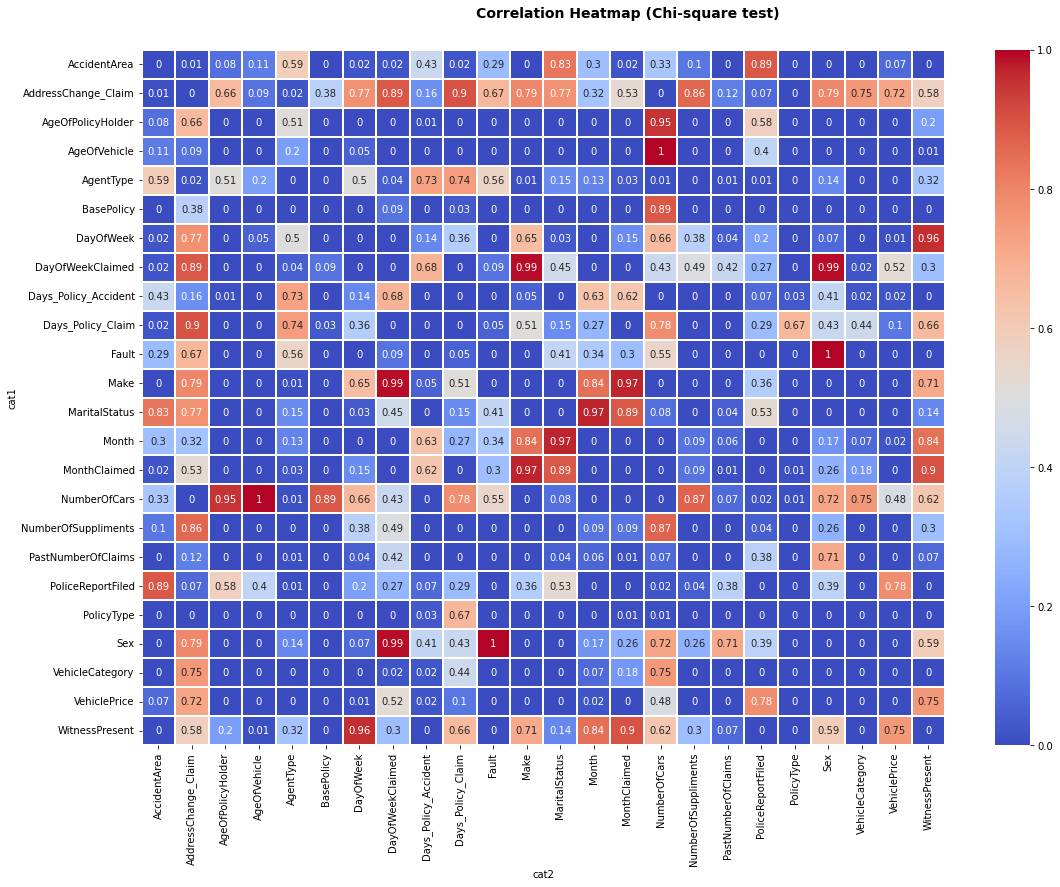

In [23]:
fig, ax = plt.subplots(1,1, figsize=(18,12))

hm = sns.heatmap(round(chisquare.pivot_table(index='cat1', columns='cat2', values='p-value'),2), 
                 ax=ax,           # Axes in which to draw the plot, otherwise use the currently-active Axes.
                 cmap="coolwarm", # Color Map.
                 #square=True,    # If True, set the Axes aspect to “equal” so each cell will be square-shaped.
                 annot=True, 
                 #annot_kws={"size": 14},
                 linewidths=.05)

fig.subplots_adjust(top=0.93)

t = fig.suptitle('Correlation Heatmap (Chi-square test)', fontsize=14, fontweight='bold')

The following correlations have a correlation coefficient that is higher than our threshold:

1. NumberOfCars - AgeOfPolicyHolder, AgeOfVehicle, BasePolicy, NumberOfSuppliments
2. NumberOfSuppliments - AddressChange_Claim 
3. AddressChange_Claim - DayOfWeekClaimed, Days_Policy_Claim
4. DayOfWeekClaimed - Make, Sex
5. Sex - Fault
6. Make - MonthClaimed
7. MonthClaimed - WitnessPresent, MaritalStatus
8. WitnessPresent - Month

After considering the relationships above, we decided the **minimum features** needed are Make, AccidentArea, Sex, MaritalStatus, PolicyType, VehicleCategory, VehiclePrice, Days_Policy_Accident, PastNumberOfClaims, WitnessPresent, AgentType,  AddressChange_Claim, NumberOfCars

## Variable Treatment and Data Processing

We now proceed to tweak our dataset with our findings by removing unwanted features and replacing the "Age" = 0 with the median value of the "Age" variable. We will also encode values to the remaining categorical variables and split our tweaked dataset into training and testing data.

In [88]:
new_numerical_variables = ["WeekOfMonth", "WeekOfMonthClaimed", "Age", "PolicyNumber", "RepNumber", 
                           "Deductible", "DriverRating"]
new_categorical_variables = ["Make", "AccidentArea", "Sex", "MaritalStatus", "PolicyType", "VehicleCategory", 
                             "VehiclePrice", "Days_Policy_Accident", "PastNumberOfClaims", "WitnessPresent", 
                             "AgentType",  "AddressChange_Claim", "NumberOfCars"]
new_variables = ["WeekOfMonth", "WeekOfMonthClaimed", "Age", "PolicyNumber", "RepNumber", "Deductible", "DriverRating",
                "Make", "AccidentArea", "Sex", "MaritalStatus", "PolicyType", "VehicleCategory", "VehiclePrice", 
                 "Days_Policy_Accident", "PastNumberOfClaims", "WitnessPresent", 
                 "AgentType",  "AddressChange_Claim", "NumberOfCars", "FraudFound_P"]
fraud_df_tweaked = fraud_df[new_variables]
fraud_df_tweaked.head()

,WeekOfMonth,WeekOfMonthClaimed,Age,PolicyNumber,RepNumber,Deductible,DriverRating,Make,AccidentArea,Sex,...,PolicyType,VehicleCategory,VehiclePrice,Days_Policy_Accident,PastNumberOfClaims,WitnessPresent,AgentType,AddressChange_Claim,NumberOfCars,FraudFound_P
0,5,1,21,1,12,300,1,Honda,Urban,Female,...,Sport - Liability,Sport,more than 69000,more than 30,none,No,External,1 year,3 to 4,0
1,3,4,34,2,15,400,4,Honda,Urban,Male,...,Sport - Collision,Sport,more than 69000,more than 30,none,No,External,no change,1 vehicle,0
2,5,2,47,3,7,400,3,Honda,Urban,Male,...,Sport - Collision,Sport,more than 69000,more than 30,1,No,External,no change,1 vehicle,0
3,2,1,65,4,4,400,2,Toyota,Rural,Male,...,Sedan - Liability,Sport,20000 to 29000,more than 30,1,No,External,no change,1 vehicle,0
4,5,2,27,5,3,400,1,Honda,Urban,Female,...,Sport - Collision,Sport,more than 69000,more than 30,none,No,External,no change,1 vehicle,0


In [89]:
fraud_df_tweaked["Age"] = fraud_df_tweaked["Age"].replace(0,fraud_df_tweaked["Age"].median())

In [90]:
for labels, content in fraud_df_tweaked.items():
    if pd.api.types.is_string_dtype(content):
        fraud_df_tweaked[labels] = content.astype("category").cat.as_ordered()

In [91]:
for labels, content in fraud_df_tweaked.items():
    if not pd.api.types.is_numeric_dtype(content):
        # Add binary column to indicate whether sample had missing values 
       #df_temp[labels+"_is_missing"] = pd.isnull(content) # Though we don't have but we could've used if we had missing values
        fraud_df_tweaked[labels] = pd.Categorical(content).codes

fraud_df_tweaked.head()

,WeekOfMonth,WeekOfMonthClaimed,Age,PolicyNumber,RepNumber,Deductible,DriverRating,Make,AccidentArea,Sex,...,PolicyType,VehicleCategory,VehiclePrice,Days_Policy_Accident,PastNumberOfClaims,WitnessPresent,AgentType,AddressChange_Claim,NumberOfCars,FraudFound_P
0,5,1,21,1,12,300,1,6,1,0,...,5,1,5,3,3,0,0,0,2,0
1,3,4,34,2,15,400,4,6,1,1,...,4,1,5,3,3,0,0,3,0,0
2,5,2,47,3,7,400,3,6,1,1,...,4,1,5,3,0,0,0,3,0,0
3,2,1,65,4,4,400,2,17,0,1,...,2,1,0,3,0,0,0,3,0,0
4,5,2,27,5,3,400,1,6,1,0,...,4,1,5,3,3,0,0,3,0,0


In [185]:
number_of_positive = fraud_df_tweaked[fraud_df_tweaked["FraudFound_P"] == 1]
number_of_negative = fraud_df_tweaked[fraud_df_tweaked["FraudFound_P"] == 0]
print("Number of fraud cases: " + str(number_of_positive.shape[0]))
print("Number of non-fraud cases: " + str(number_of_negative.shape[0]))

Number of fraud cases: 923
Number of non-fraud cases: 14497


Our dataset is heavily imbalanced towards non-fraud cases, hence we will use SMOTE to balance the dataset. 

In [189]:
sm = SMOTE(random_state=42)
X = fraud_df_tweaked.drop("FraudFound_P",axis = 1)
y = fraud_df_tweaked["FraudFound_P"]
X_sm, y_sm = sm.fit_resample(X, y)

print(f'''Shape of X before SMOTE: {X.shape}
Shape of X after SMOTE: {X_sm.shape}''')

print('\nBalance of positive and negative classes (%):')
y_sm.value_counts(normalize=True) * 100

Shape of X before SMOTE: (15420, 20)
Shape of X after SMOTE: (28994, 20)

Balance of positive and negative classes (%):


0    50.0
1    50.0
Name: FraudFound_P, dtype: float64

In [191]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_sm,y_sm,test_size=0.2, random_state = 42)

## Model Training

We now train models that will aid us in predicting a fraudulent claim. The models are:
1. Logistic Regression
2. Naive Bayes
3. K Nearest Neighbour
4. XGBoost
5. Random Forest

In [205]:
# Function to obtain necessary performance metrics
def get_statistics(model, X_train, y_train, X_test, y_test):
    prediction_using_training_data = model.predict(X_train)
    prediction_using_test_data = model.predict(X_test)
    pred_prob = model.predict_proba(X_test)[:, 1]
    print(f'Train Accuracy = {accuracy_score(y_train, prediction_using_training_data):.4f}')
    print(f'Test Accuracy = {accuracy_score(y_test, prediction_using_test_data):.4f}')
    print(f'Test AUC = {roc_auc_score(y_test, prediction_using_test_data):.4f}')
    print(f'Test Recall = {recall_score(y_test, prediction_using_test_data):.4f}')
    print(f'Test F1 = {f1_score(y_test, prediction_using_test_data):.4f}')
    print(f'Test Precision = {precision_score(y_test, prediction_using_test_data):.4f}')

In [206]:
# Function to generte confusion matrix
def conf_plot(y_test, y_preds):
    """
    Plots a nice looking heatmap on seaborn
    """
    fix, ax = plt.subplots(figsize=(10,6))
    ax = sns.heatmap(confusion_matrix(y_test, y_preds),
                     annot=True,
                     cbar=True,
                     fmt="g",
                    cmap="Blues");
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")

### 1. Logistic Regression

In [207]:
from sklearn.utils import class_weight
class_weights = dict(zip(np.unique(y_train), 
                         class_weight.compute_class_weight(
                          class_weight='balanced',
                          classes= np.unique(y_train), 
                          y = y_train)))

In [210]:
np.random.seed(1)
logregModel = LogisticRegression(class_weight = class_weights, solver='liblinear')
logregModel.fit(X_train, y_train)
get_statistics(logregModel, X_train, y_train, X_test, y_test)

Train Accuracy = 0.7463
Test Accuracy = 0.7427
Test AUC = 0.7427
Test Recall = 0.7966
Test F1 = 0.7559
Test Precision = 0.7192


Our current model has an AUC score of 0.7427. We will now attempt to fine tune our model by finding the optimal hyperparameters for Logistic Regression.

In [211]:
param_grid = [
    {'penalty':['l1','l2','elasticnet','none'], 
     # penalty{‘l1’, ‘l2’, ‘elasticnet’, ‘none’}, default=’l2’
     'C': np.logspace(-4,4,10), 
     # C: Inverse of regularization strength; must be a positive float. 
     # Like in support vector machines, smaller values specify stronger regularization.
     'max_iter':[100,1000]} 
     # Maximum number of iterations taken for the solvers to converge.
]

In [212]:
clf = GridSearchCV(logregModel, param_grid = param_grid, cv = 3, verbose = True, n_jobs = -1) 
best_clf = clf.fit(X_train, y_train)
best_clf.best_estimator_

Fitting 3 folds for each of 80 candidates, totalling 240 fits


LogisticRegression(C=21.54434690031882,
                   class_weight={0: 0.9999568891188136, 1: 1.000043114598603},
                   solver='liblinear')

In [213]:
logregModel = LogisticRegression(C=best_clf.best_estimator_.C,
                   class_weight={0: best_clf.best_estimator_.class_weight[0], 
                                 1: best_clf.best_estimator_.class_weight[1]},
                   penalty=best_clf.best_estimator_.penalty, 
                   solver=best_clf.best_estimator_.solver)
logregModel.fit(X_train, y_train)
get_statistics(logregModel, X_train, y_train, X_test, y_test)

Train Accuracy = 0.7490
Test Accuracy = 0.7469
Test AUC = 0.7468
Test Recall = 0.7962
Test F1 = 0.7588
Test Precision = 0.7247


After hyperparameter tuning, we have managed to improve the performance metrics of our Logistic Regression model.

Confusion Matrix:  [[2022  877]
 [ 591 2309]]


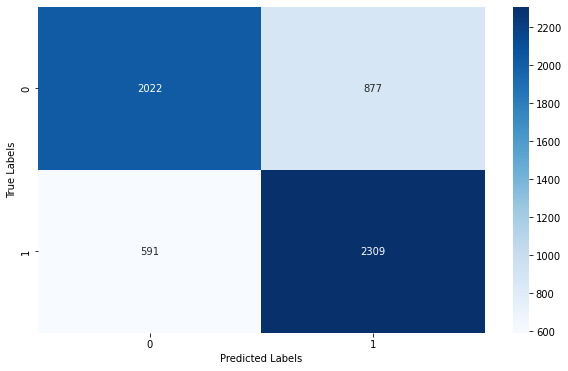

In [268]:
predictions = logregModel.predict(X_test)
print('Confusion Matrix: ', confusion_matrix(y_test, predictions))
conf_plot(y_test, predictions)

In [269]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.77      0.70      0.73      2899
           1       0.72      0.80      0.76      2900

    accuracy                           0.75      5799
   macro avg       0.75      0.75      0.75      5799
weighted avg       0.75      0.75      0.75      5799



Feature: 0, Score: -0.0552
Feature: 1, Score: -0.1952
Feature: 2, Score: -0.0291
Feature: 3, Score: 0.0000
Feature: 4, Score: -0.0278
Feature: 5, Score: -0.0010
Feature: 6, Score: -0.2931
Feature: 7, Score: -0.0555
Feature: 8, Score: -1.0172
Feature: 9, Score: -0.3911
Feature: 10, Score: -1.4704
Feature: 11, Score: 0.2054
Feature: 12, Score: -2.6929
Feature: 13, Score: 0.1465
Feature: 14, Score: -0.4257
Feature: 15, Score: -0.2123
Feature: 16, Score: -2.4818
Feature: 17, Score: -3.2410
Feature: 18, Score: -0.5484
Feature: 19, Score: -0.7228


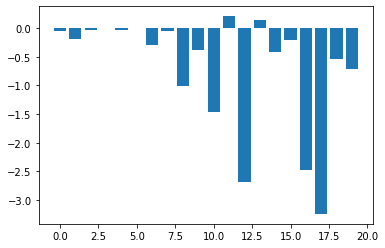

In [217]:
# plot feature importance
importance = logregModel.coef_[0]
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.4f' % (i,v))
plt.bar([x for x in range(len(importance))], importance)
plt.show()

### 2.Naive Bayes

In [219]:
NB_model = GaussianNB()
NB_model.fit(X_train, y_train)
get_statistics(NB_model, X_train, y_train, X_test, y_test)

Train Accuracy = 0.7246
Test Accuracy = 0.7218
Test AUC = 0.7218
Test Recall = 0.8610
Test F1 = 0.7559
Test Precision = 0.6736


Our current model has an AUC score of 0.7218. We will now attempt to fine tune the model by finding the optimal hyperparameters for Naive Bayes.

In [220]:
param_grid_nb = [
    {'priors': [[0.1,0.9], [0.2,0.8], [0.3,0.7], [0.4,0.6], [0.5,0.5], [0.6,0.4], [0.7,0.3], [0.8,0.2], [0.9,0.1]], 
     # Prior probabilities of the classes
     'var_smoothing': np.logspace(0,-9, num=100) 
     #var_smoothing is a stability calculation to widen (or smooth) the curve 
     # and therefore account for more samples that are further away from the distribution mean. 
    }
]

In [221]:
clf = GridSearchCV(NB_model, param_grid = param_grid_nb, cv = 3, verbose = True, n_jobs = -1)
best_clf = clf.fit(X_train, y_train)
best_clf.best_estimator_

Fitting 3 folds for each of 900 candidates, totalling 2700 fits


GaussianNB(priors=[0.7, 0.3], var_smoothing=6.579332246575682e-09)

In [222]:
NB_model = GaussianNB(priors = best_clf.best_estimator_.priors, 
                      var_smoothing = best_clf.best_estimator_.var_smoothing) 
NB_model.fit(X_train, y_train)
get_statistics(NB_model, X_train, y_train, X_test, y_test)

Train Accuracy = 0.7542
Test Accuracy = 0.7538
Test AUC = 0.7538
Test Recall = 0.7431
Test F1 = 0.7511
Test Precision = 0.7593


After hyperparameter tuning, we have improved our performance metrics for the Naive Bayes model. However, our Recall and F1 Score has decreased after hyperparameter tuning. 

Confusion Matrix:  [[2216  683]
 [ 745 2155]]


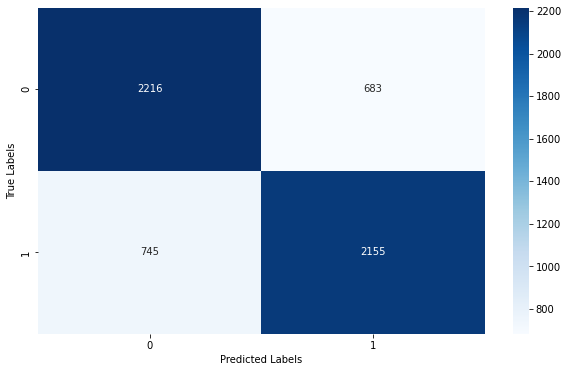

In [266]:
predictions = NB_model.predict(X_test)
print('Confusion Matrix: ', confusion_matrix(y_test, predictions))
conf_plot(y_test, predictions)

In [267]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.75      0.76      0.76      2899
           1       0.76      0.74      0.75      2900

    accuracy                           0.75      5799
   macro avg       0.75      0.75      0.75      5799
weighted avg       0.75      0.75      0.75      5799



### 3. K Nearest Neighbour

We first attempt a k nearest neighbour with 1 neighbour and assess the performance. 

In [229]:
k_neighbors = KNeighborsClassifier(n_neighbors=1)
k_neighbors.fit(X_train, y_train)
get_statistics(k_neighbors, X_train, y_train, X_test, y_test)

Train Accuracy = 1.0000
Test Accuracy = 0.8470
Test AUC = 0.8470
Test Recall = 0.9590
Test F1 = 0.8625
Test Precision = 0.7836


It seems that we have 100% training accuracy which could indicate overfitting. We will now attempt hyperparameter tuning to avoid this and the hyperparameters targeted are the number of neighbours and the Minkowski formula (Manhattan vs Euclidean). 

In [227]:
n_neighbors = list(range(1,10))
p = [1,2]
#Convert to dictionary
hyperparameters = dict(n_neighbors=n_neighbors, p=p)
#Create new KNN object
knn_2 = KNeighborsClassifier()
#Use GridSearch
clf = GridSearchCV(knn_2, hyperparameters, cv = 3)
#Fit the model
best_model = clf.fit(X_train,y_train)
#Print The value of best Hyperparameters

print('Best p:', best_model.best_estimator_.get_params()['p'])
print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])

Best p: 1
Best n_neighbors: 2


With tuning, we have found the optimal number of neighbours to be 2 and we will use Manhattan distance for the Minkowski formula.

In [230]:
k_neighbors = KNeighborsClassifier(n_neighbors=2, p=1)
k_neighbors.fit(X_train, y_train)
get_statistics(k_neighbors, X_train, y_train, X_test, y_test)

Train Accuracy = 0.9904
Test Accuracy = 0.8898
Test AUC = 0.8898
Test Recall = 0.9521
Test F1 = 0.8963
Test Precision = 0.8467


Our overall performance metrics have gone up and the training accuracy has been reduced. 

Confusion Matrix:  [[2399  500]
 [ 139 2761]]


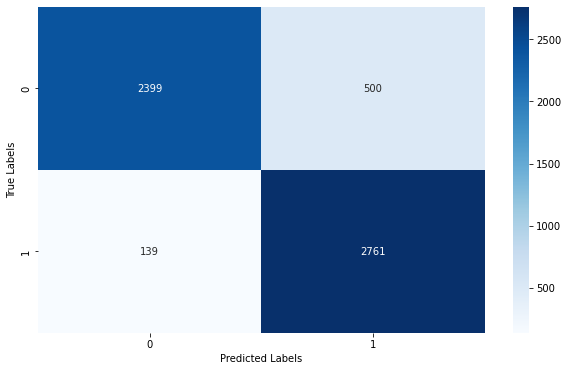

In [264]:
predictions = k_neighbors.predict(X_test)
print('Confusion Matrix: ', confusion_matrix(y_test, predictions))
conf_plot(y_test, predictions)

In [265]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.95      0.83      0.88      2899
           1       0.85      0.95      0.90      2900

    accuracy                           0.89      5799
   macro avg       0.90      0.89      0.89      5799
weighted avg       0.90      0.89      0.89      5799



### 4. XGBoost

We first train an XGBoost model using the default parameters.

In [232]:
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)
get_statistics(xgb_model, X_train, y_train, X_test, y_test)

Train Accuracy = 0.9691
Test Accuracy = 0.9364
Test AUC = 0.9364
Test Recall = 0.9303
Test F1 = 0.9360
Test Precision = 0.9417


We now conduct hyperparameter tuning for XGBoost to find the optimal number of trees. 

In [233]:
xgb_param = xgb_model.get_xgb_params()
xgtrain = xgb.DMatrix(X, label=y)

cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=xgb_model.get_params()['n_estimators'], nfold=100,
            metrics='auc', early_stopping_rounds=50)
xgb_model.set_params(n_estimators=cvresult.shape[0])

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)

Result: Found that optimal number of trees is 100.

In [234]:
space={
    'objective': 'binary:logistic', 
    'use_label_encoder': False, 
    'base_score': 0.5,
    'booster': 'gbtree',
    'colsample_bylevel' : 1,
    'colsample_bynode' : 1,
    'colsample_bytree' : hp.uniform('colsample_bytree', 0.6, 0.9),
    'enable_categorical': False,
    'gamma': hp.uniform('gamma', 0,10),
    'gpu_id': -1,
    'importance_type': None,
    'interaction_constraints': '', 
    'learning_rate': 0.300000012, 
    'max_delta_step': 0,
    'max_depth': hp.randint("max_depth", 8)+3,
    'min_child_weight' : hp.randint('min_child_weight', 4)+1,
    'monotone_constraints': '()',
    'n_estimators': 100,
    'n_jobs': -1,
    'num_parallel_tree':1, 
    'predictor':'auto', 
    'random_state': 0,
    #regularization parameters
    'reg_alpha' : hp.randint('reg_alpha', 10),
    'reg_lambda' : hp.randint('reg_lambda', 10),
    'scale_pos_weight': 1,
    'subsample': hp.uniform('subsample', 0.6, 0.9),
    'tree_method': 'exact',
    'validate_parameters':1,
    'verbosity': None,
    'eval_metric': 'aucpr'
    }

In [235]:
def objective(space):
    base_xgb_model = XGBClassifier(**space)
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    base_xgb_model.fit(X_train, y_train,
            eval_set=evaluation,
            early_stopping_rounds=10,verbose=False)
    

    pred = base_xgb_model.predict(X_test)
    accuracy = accuracy_score(y_test, pred>0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [236]:
trials = Trials()
best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

SCORE:                                                 
0.8930850146576996                                     
SCORE:                                                                            
0.9179168822210726                                                                
SCORE:                                                                            
0.9073978272115882                                                                
SCORE:                                                                            
0.911364028280738                                                                 
SCORE:                                                                            
0.9156751163993792                                                                
SCORE:                                                                            
0.9111915847559924                                                                
SCORE:                                                    

0.9117089153302294                                                                 
SCORE:                                                                             
0.9339541300224177                                                                 
SCORE:                                                                             
0.9458527332298672                                                                 
100%|██████████| 100/100 [02:43<00:00,  1.64s/trial, best loss: -0.9458527332298672]


In [237]:
best_hyperparams

{'colsample_bytree': 0.7908435165589236,
 'gamma': 1.0285048623640485,
 'max_depth': 6,
 'min_child_weight': 1,
 'reg_alpha': 0,
 'reg_lambda': 0,
 'subsample': 0.7324763115242703}

In [238]:
optimized_xgb_model = XGBClassifier(
    objective= 'binary:logistic', 
    use_label_encoder= False, 
    base_score= 0.5, 
    booster= 'gbtree', 
    colsample_bylevel= 1, 
    colsample_bynode= 1, 
    colsample_bytree= best_hyperparams['colsample_bytree'], 
    enable_categorical= False, 
    gamma= best_hyperparams['gamma'], 
    gpu_id= -1, 
    importance_type= None, 
    interaction_constraints= '', 
    learning_rate= 0.300000012, 
    max_delta_step= 0, 
    max_depth= best_hyperparams['max_depth'], 
    min_child_weight= best_hyperparams['min_child_weight'], 
    monotone_constraints= '()',
    n_estimators= 100, 
    n_jobs= 4, 
    num_parallel_tree= 1, 
    predictor= 'auto', 
    random_state= 0, 
    reg_alpha= best_hyperparams['reg_alpha'], 
    reg_lambda= best_hyperparams['reg_lambda'], 
    scale_pos_weight= 1, 
    subsample= best_hyperparams['subsample'], 
    tree_method= 'exact', 
    validate_parameters= 1, 
    verbosity= None, 
    eval_metric= 'aucpr'
)
print(optimized_xgb_model.get_params())

{'objective': 'binary:logistic', 'use_label_encoder': False, 'base_score': 0.5, 'booster': 'gbtree', 'callbacks': None, 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.7908435165589236, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': 'aucpr', 'feature_types': None, 'gamma': 1.0285048623640485, 'gpu_id': -1, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': '', 'learning_rate': 0.300000012, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': 0, 'max_depth': 6, 'max_leaves': None, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 100, 'n_jobs': 4, 'num_parallel_tree': 1, 'predictor': 'auto', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 0, 'sampling_method': None, 'scale_pos_weight': 1, 'subsample': 0.7324763115242703, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None}


In [239]:
xgb_model = optimized_xgb_model.fit(X_train, y_train)
get_statistics(xgb_model, X_train, y_train, X_test, y_test)

Train Accuracy = 0.9705
Test Accuracy = 0.9327
Test AUC = 0.9327
Test Recall = 0.9241
Test F1 = 0.9322
Test Precision = 0.9404


Confusion Matrix:  [[2729  170]
 [ 220 2680]]


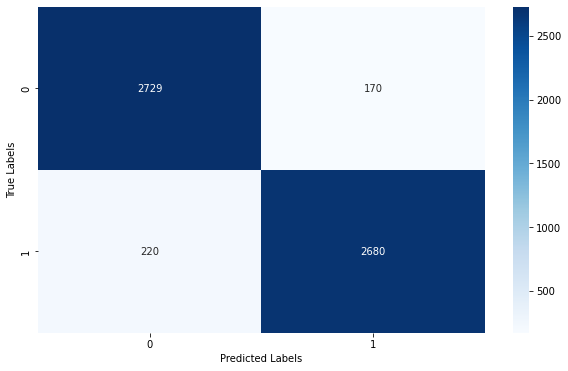

In [242]:
predictions = xgb_model.predict(X_test)
print('Confusion Matrix: ', confusion_matrix(y_test, predictions))
conf_plot(y_test, predictions)

We now attempt to fine tune the model even further by reducing the learning rate and increasing the number of trees.

In [243]:
xgb_model.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': False,
 'base_score': 0.5,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 0.7908435165589236,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': 'aucpr',
 'feature_types': None,
 'gamma': 1.0285048623640485,
 'gpu_id': -1,
 'grow_policy': 'depthwise',
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_bin': 256,
 'max_cat_threshold': 64,
 'max_cat_to_onehot': 4,
 'max_delta_step': 0,
 'max_depth': 6,
 'max_leaves': 0,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 4,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 0,
 'sampling_method': 'uniform',
 'scale_pos_weight': 1,
 'subsample': 0.7324763115242703,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

In [244]:
final_xgb_model = XGBClassifier(objective= 'binary:logistic', 
                              use_label_encoder= False, 
                              base_score= 0.5, 
                              booster= 'gbtree', 
                              colsample_bylevel= 1, 
                              colsample_bynode= 1, 
                              colsample_bytree= best_hyperparams['colsample_bytree'], 
                              enable_categorical= False, 
                              gamma= best_hyperparams['gamma'], 
                              gpu_id= -1, 
                              importance_type= None, 
                              interaction_constraints= '', 
                              learning_rate= 0.1, 
                              max_delta_step= 0, 
                              max_depth= best_hyperparams['max_depth'], 
                              min_child_weight= best_hyperparams['min_child_weight'], 
                              monotone_constraints= '()',
                              n_estimators= 1000, 
                              n_jobs= 4, 
                              num_parallel_tree= 1, 
                              predictor= 'auto', 
                              random_state= 0, 
                              reg_alpha= best_hyperparams['reg_alpha'], 
                              reg_lambda= best_hyperparams['reg_lambda'], 
                              scale_pos_weight= 1, 
                              subsample= 1, 
                              tree_method= 'exact', 
                              validate_parameters= 1, 
                              verbosity= None, 
                              eval_metric= 'aucpr')

In [245]:
import warnings
warnings.filterwarnings("ignore")

# Cross-validated ROC_AUC
cv_roc_auc = cross_val_score(final_xgb_model,
                         X,
                         y,
                         cv=100,
                         scoring="roc_auc")
# Let's take over all mean of the accuracy
cv_adjusted = np.mean(cv_roc_auc) * 100
print(f"The cross validated ROC_AUC for our XGboost Classifier is: {cv_adjusted : .2f}%")

The cross validated ROC_AUC for our XGboost Classifier is:  39.90%


In [246]:
xgb_model = final_xgb_model.fit(X_train, y_train)
get_statistics(xgb_model, X_train, y_train, X_test, y_test)

Train Accuracy = 0.9903
Test Accuracy = 0.9462
Test AUC = 0.9462
Test Recall = 0.9407
Test F1 = 0.9459
Test Precision = 0.9512


Further tuning of hyperparameters have improved our performance metrics. 

Confusion Matrix:  [[2759  140]
 [ 172 2728]]


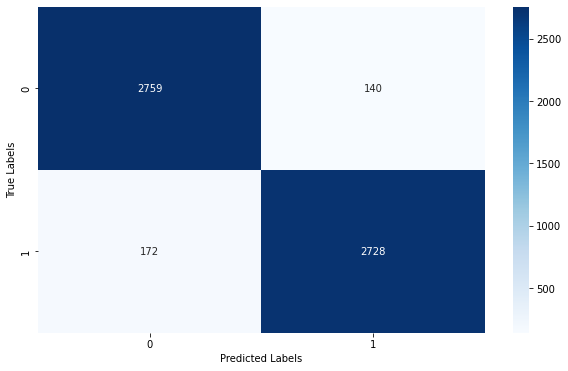

In [262]:
predictions = final_xgb_model.predict(X_test)
print('Confusion Matrix: ', confusion_matrix(y_test, predictions))
conf_plot(y_test, predictions)

In [263]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.94      0.95      0.95      2899
           1       0.95      0.94      0.95      2900

    accuracy                           0.95      5799
   macro avg       0.95      0.95      0.95      5799
weighted avg       0.95      0.95      0.95      5799



In [249]:
def plot_features(columns, importances, n=20):
    df_feat = (pd.DataFrame({"features":columns,
                             "features_importances": importances})
          .sort_values("features_importances",ascending=False)
          .reset_index(drop=True))
    
    # Plot the dataframe we created
    fig, ax = plt.subplots(figsize=(12,7))
    ax.barh(df_feat["features"][:n], df_feat["features_importances"][:20])
    ax.set_ylabel("Features")
    ax.set_xlabel("Features Importance")
    ax.invert_yaxis()

In [250]:
final_xgb_model.feature_importances_

array([0.01514037, 0.01583293, 0.01256143, 0.01453941, 0.01531456,
       0.02156344, 0.02877854, 0.06594384, 0.04194672, 0.01484019,
       0.05032757, 0.10850441, 0.3759387 , 0.03889466, 0.01083231,
       0.03476711, 0.01559635, 0.02583589, 0.03302093, 0.05982063],
      dtype=float32)

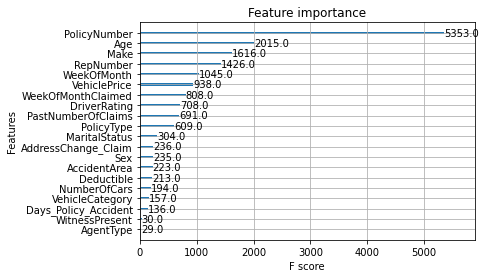

In [251]:
plot_importance(final_xgb_model, max_num_features=20);

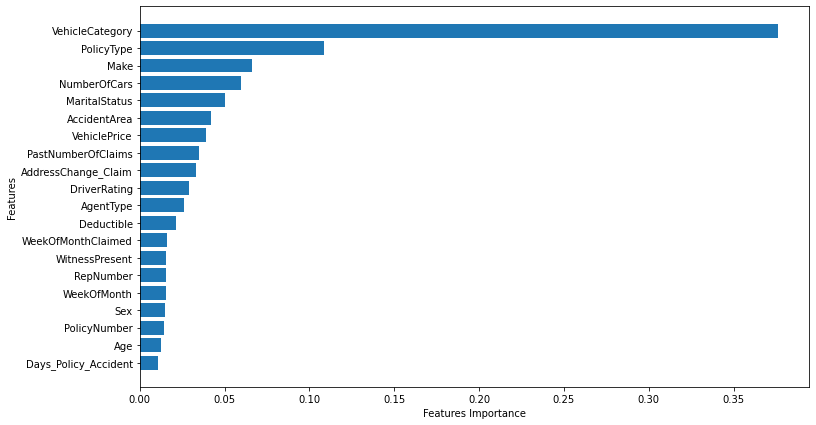

In [252]:
plot_features(X_train.columns, final_xgb_model.feature_importances_)

### 5. Random Forest

In [253]:
rf_model_sm = RandomForestClassifier(random_state=42)
rf_model_sm.fit(X_train, y_train)
get_statistics(rf_model_sm, X_train, y_train, X_test, y_test)

Train Accuracy = 1.0000
Test Accuracy = 0.9336
Test AUC = 0.9336
Test Recall = 0.9345
Test F1 = 0.9337
Test Precision = 0.9329


Our model currently has 100% training accuracy, which exposes us to overfitting. We now tune our hyperparameters to avoid this issue.

In [254]:
param_grid = { 
    'n_estimators': np.append(100, np.arange(10, 500,50)),
    'max_features': [None, 'auto', 'sqrt', 'log2'],
    'max_depth' : [None, 3, 4, 5, 6, 7, 8],
    'criterion' :['gini', 'entropy'], 
    'min_samples_split': np.arange(2, 20, 2),
    'min_samples_leaf': np.arange(1, 20, 2)
}

In [255]:
RS_rfc_sm = RandomizedSearchCV(estimator=rf_model_sm, param_distributions=param_grid, cv= 3, n_iter=5, n_jobs=-1, scoring = "roc_auc")
best_params_sm = RS_rfc_sm.fit(X_train, y_train)

In [256]:
rf_model_rs_sm = best_params_sm.best_estimator_
rf_model_rs_sm.fit(X_train, y_train)
get_statistics(rf_model_rs_sm, X_train, y_train, X_test, y_test)

Train Accuracy = 0.8119
Test Accuracy = 0.8108
Test AUC = 0.8108
Test Recall = 0.8759
Test F1 = 0.8224
Test Precision = 0.7751


Hyperparameter tuning has allowed us to avoid overfitting but our performance metrics have dropped.

Confusion Matrix:  [[2162  737]
 [ 360 2540]]


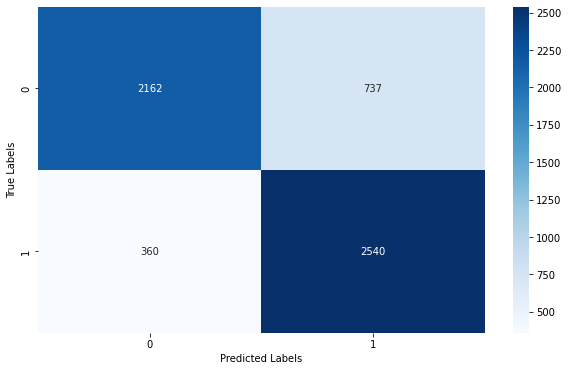

In [270]:
predictions = rf_model_rs_sm.predict(X_test)
print('Confusion Matrix: ', confusion_matrix(y_test, predictions))
conf_plot(y_test, predictions)

In [271]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.86      0.75      0.80      2899
           1       0.78      0.88      0.82      2900

    accuracy                           0.81      5799
   macro avg       0.82      0.81      0.81      5799
weighted avg       0.82      0.81      0.81      5799

